### Run Ocetrac


In [18]:
import xarray as xr
import numpy as np
import ocetrac


#### Import MHW candidate data

In [13]:
ds_new = xr.open_dataset('~/marine-heatwaves/data/mhw_candidates.nc')

ds_new

<xarray.Dataset>
Dimensions:   (time: 478, lat: 720, lon: 1440)
Coordinates:
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time      (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
Data variables:
    mhw_ssta  (time, lat, lon) float64 ...
    prct_90   (lat, lon) float64 ...
Attributes:
    description:  OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

#### Adjust land mask to ignore points poleward of 65ºN and 70ºS

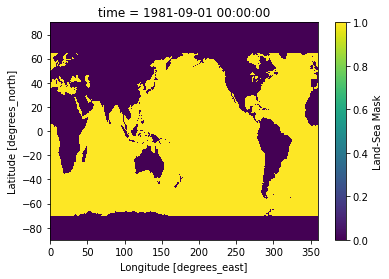

In [14]:
path = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/lsmask.oisst.nc'
mask = xr.open_dataset(path, use_cftime=True) 
lsmask = mask.lsmask.isel(time=0).where((mask.lat<65) & (mask.lat>-70), drop=False, other=0) 
lsmask.plot()

### Run Ocetrac

In [15]:
# Set model parameters
da = ds_new.mhw_ssta.load() # load the DataArray into memory
radius = 8 # radius for structuring element
min_size_quartile = 0.75 # threshold for object areas
timedim = 'time'
xdim = 'lon'
ydim = 'lat'

In [16]:
Tracker =  ocetrac.Tracker(da, lsmask, radius, min_size_quartile, timedim, xdim, ydim, positive=True)

In [17]:
%%time 
blobs = Tracker.track()

minimum area: 2487.0
inital objects identified 	 12704
final objects tracked 	 779
CPU times: user 10min 16s, sys: 2min 11s, total: 12min 27s
Wall time: 12min 30s


**The basic output of `Tracker.track` provides:**
- the minimum object area used to filter out MHWs that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MHW objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MHW objects tracked in space and time. 

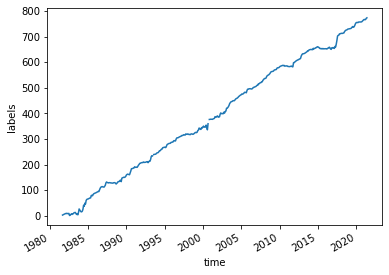

In [19]:
blobs.mean(('lat','lon')).plot()

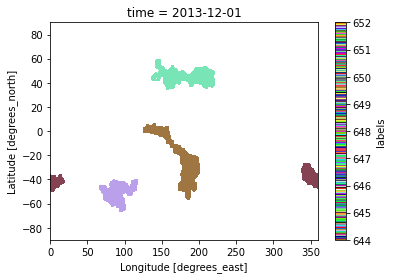

In [23]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

# Make a quick plot of the labeled MHWs identified with Ocetrac
blobs.sel(time=('2013-12-01')).plot(cmap= cm)

### Save tracked labels

In [30]:
blobs.attrs

{'inital objects identified': 12704,
 'final objects tracked': 779,
 'radius': 8,
 'size quantile threshold': 0.75,
 'min area': 2487.0,
 'percent area reject': 0.19759675219466732,
 'percent area accept': 0.8024032478053327}

In [32]:
# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        blobs=(['time', 'lat', 'lon'], blobs.values, blobs.attrs),
        lsmask=(['lat', 'lon'], lsmask.values),

    ),
    coords=dict(
        lon=ds_new.lon,
        lat=ds_new.lat,
        time=ds_new.time,
    ),
    attrs=dict(description="Ocetrac labels",
               data="OISST v2.1 preprocessed for Ocetrac",
               threshold='90th percentile',
               climatology='entire period'),
)
ds_out

<xarray.Dataset>
Dimensions:  (time: 478, lat: 720, lon: 1440)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
Data variables:
    blobs    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    lsmask   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  Ocetrac labels
    data:         OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

In [34]:
ds_out.to_netcdf('~/marine-heatwaves/data/ocetrac_labels.nc')